# Test model for colloidal system 

**Author:** HOOMD-blue, YeNguyenEdalgo

Simulation of 125 particles interacting through Lennard Jones potential and dipole-dipole interactions

## Initialize

Import the hoomd python package and the md component to execute MD simulations.

In [177]:
from math import *
import hoomd
import hoomd.md
import hoomd.deprecated
import numpy 
from matplotlib import pyplot as plt 
import gsd 
import gsd.hoomd
import gsd.pygsd

Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [178]:
hoomd.context.initialize("");

## Parameters

In [179]:
change_seed = 45475945
type="Dipole_1"
Equil_fname="trajectory_Equilibrate.gsd"
"""Lennard-Jones style Normalized parameters"""
kB_r            = 1 
mass_r          = 1 
LJ_sigma_r      = 1 
LJ_epsilon_r    = 1 
r_cut_LJ_r      = 1
r_cut_dd_r      = 2*r_cut_LJ_r
time_step_r     = 0.005
drag_coeff_r    = 1
T_r             = 0.2
dipole_moment_r = 1
total_step      = 1e6
log_period_r    = 1e3

Initialize a $n$ by $n$ by $n$ simple cubic lattice of particles. The lattice initializer by default creates all particles named type "A", and with 0 velocity.

In [180]:
#system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5);
system = hoomd.init.read_gsd(Equil_fname, frame=-1)

notice(2): Group "all" created containing 125 particles


## Lennard Jones potential model

\begin{equation}
    U_{LJ} = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] 
\end{equation}

In the Lennard-Jones system, pairs of particles closer than $r_\mathrm{cut}$ interact with this potential energy.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [181]:
nl = hoomd.md.nlist.cell();

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [182]:
lj = hoomd.md.pair.lj(r_cut=r_cut_LJ_r, nlist=nl)

Specify pair potential parameters for every pair of types in the simulation.

In [183]:
lj.pair_coeff.set('A', 'A', epsilon=LJ_epsilon_r, sigma=LJ_sigma_r);

## Dipole-dipole inter-particle interaction model

\begin{equation}
    U_{dipole} = U_{dd} + U_{de} + U_{ee}
\label{U_dipole_hoomd}
\end{equation}

where $U_{dd}$ is the potential for dipole-dipole interaction, $U_{de}$, and $U_{ee}$ account for the potentials from electrostatic charges.

\begin{equation}
    U_{dd} = A\exp^{-\kappa r} 
    \Bigg[
    \frac{\vec{\mu}_i\cdot \vec{\mu}_j}{r^3}
    -3\frac{(\vec{\mu}_i\cdot \vec{r}_{ij})
    (\vec{\mu}_j\cdot\vec{r}_{ij})}{r^5}
    \Bigg]
\label{U_dd_hoomd}
\end{equation}

\begin{equation}
    U_{de} = A\exp^{-\kappa r} 
    \Bigg[
    \frac{(\vec{\mu}_i\cdot \vec{r}_{ij})q_i}{r^3}
    -\frac{(\vec{\mu}_j\cdot\vec{r}_{ij})q_j}{r^3}
    \Bigg]
\label{U_de}
\end{equation}

\begin{equation}
    U_{ee} = A\exp^{-\kappa r}
    \frac{q_i q_j}{r}
\label{U_ee}
\end{equation}

where $\vec{\mu}_i = \mu (1, 0, 0)$ is the dipole moment in which $\mu$ is the magnitude of $\vec{\mu}$

In [184]:
"""Dipole-Dipole Potential: SWITCH ON After system is equilibrated""" 

DD = hoomd.md.pair.dipole(r_cut=r_cut_dd_r, nlist=nl)
DD.pair_coeff.set('A', 'A', mu=dipole_moment_r, A=1/(4*pi), kappa=0.0)

## DVLO colloidal interaction model

In [185]:
#DLVO.pair_coeff.set('A', 'A', epsilon=1.0, kappa=1.0)
#DLVO.pair_coeff.set('A', 'A', epsilon=LJ_epsilon_r, kappa=1/LJ_sigma_r);

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [186]:
hoomd.md.integrate.mode_standard(dt=time_step_r);

Apply the Langevin equations of motion to all particles. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator.

In [187]:
all = hoomd.group.all();
hoomd.md.integrate.langevin(group=all, kT=kB_r*T_r, seed=change_seed);

notice(2): integrate.langevin/bd is using specified gamma values


## Write output

Periodically log the potential energy of the system to a text file.

In [188]:
hoomd.analyze.log(filename="log-output_"+type+".log",
                  quantities=['potential_energy', 'temperature'],
                  period=log_period_r,
                  overwrite=True);

Periodically write the particle configurations to a gsd file.

In [189]:
hoomd.dump.gsd("trajectory_"+type+".gsd", period=1e5, group=all, overwrite=True);

In [190]:
snap = system.take_snapshot(all=True)
print(snap.box)

Box: Lx=10.0 Ly=10.0 Lz=10.0 xy=0.0 xz=0.0 yz=0.0 dimensions=3


## Run the simulation

Take 10,000 steps forward in time.

In [191]:
hoomd.run(total_step);

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 128903 / 1009000 | TPS 1

*Warning*: Integrator #0: Anisotropic integration requested, but no rotational degrees of freedom found for its group


1990.3 | ETA 00:01:13
Time 00:00:20 | Step 255713 / 1009000 | TPS 12680.9 | ETA 00:00:59
Time 00:00:30 | Step 383495 / 1009000 | TPS 12778.2 | ETA 00:00:48
Time 00:00:40 | Step 507660 / 1009000 | TPS 12416.5 | ETA 00:00:40
Time 00:00:50 | Step 638200 / 1009000 | TPS 13054 | ETA 00:00:28
Time 00:01:00 | Step 768402 / 1009000 | TPS 13020.2 | ETA 00:00:18
Time 00:01:10 | Step 896825 / 1009000 | TPS 12842.3 | ETA 00:00:08
Time 00:01:18 | Step 1009000 / 1009000 | TPS 13287.3 | ETA 00:00:00
Average TPS: 12743.9
---------
-- Neighborlist stats:
32540 normal updates / 10001 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 8 / n_neigh_avg: 3.208
shortest rebuild period: 16
-- Cell list stats:
Dimension: 4, 4, 4
n_min    : 0 / n_max: 5 / n_avg: 1.95312
** run complete **


# Examine the output

Use matplotlib to plot the potential energy vs time step.

In [202]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline

data = numpy.genfromtxt(fname="log-output_"+type+".log", skip_header=True);

## Effect of dipole moment $\vec{\mu}$ on potential energy

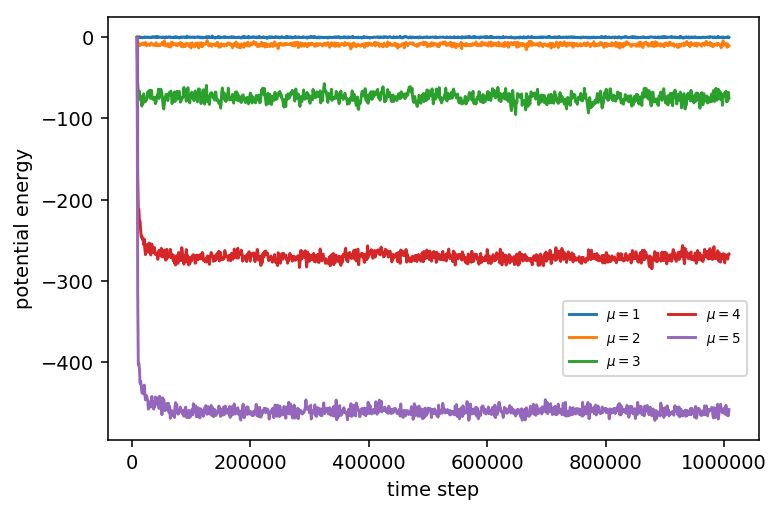

In [206]:
time_step = np.genfromtxt(fname='log-output_Dipole_1.log', skip_header=True)

plt.figure(figsize=(6,4), dpi=140);

for i in [1, 2, 3, 4, 5]:
        mu_i = np.genfromtxt(fname='log-output_Dipole_'+str(i)+'.log', skip_header=True)
        plt.plot(time_step[:,0], mu_i[:,1], label="$\mu=%d$"%(i,))

leg = plt.legend(loc=(0.7, 0.15), ncol=2, fontsize='x-small')
plt.xlabel('time step');
plt.ylabel('potential energy');
plt.savefig('Figures/PotentialEnergy_Dipole.pdf')

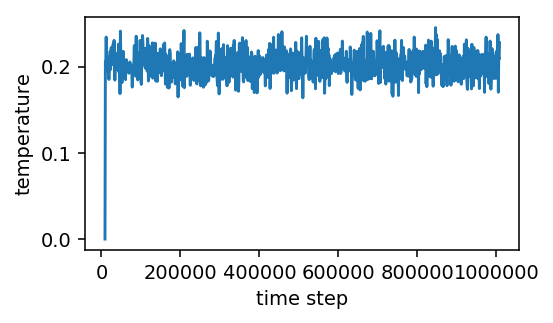

In [197]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(data[:,0], data[:,2]);
plt.xlabel('time step');
plt.ylabel('temperature');

Examine how the system configuration evolves over time. [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://bitbucket.org/glotzer/hoomd-examples) repository and designed only to render these examples.

## **Equilibrate**

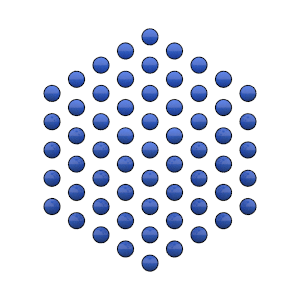

In [111]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory_Equilibrate.gsd');

## **Dipole-Dipole Interations**

**Magnitude of the dipole moment $\mu=1$**

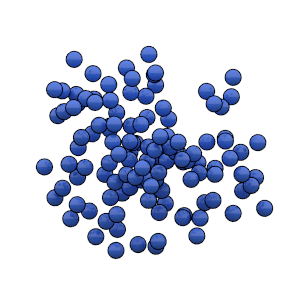

In [198]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory_Dipole_1.gsd');

**$\mu=2$**

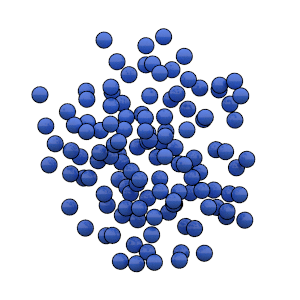

In [199]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory_Dipole_2.gsd');

**$\mu=5$**

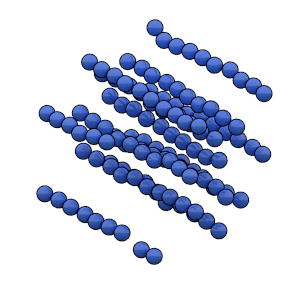

In [200]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory_Dipole_5.gsd');

## DLVO interactions for colloidal particles 

In [ ]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory_DLVO.gsd');